# 네이버 영화리뷰 감성분석
한국어 텍스트의 감정 분석 진행 - 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus 데이터셋 활용
## (1) 데이터 준비와 확인

In [1]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## (2) 데이터 로더 구성
IMDB 데이터셋과는 달리 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일이다. 데이터 로더는 다음을 수행해야 한다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- `X_train`, `y_train`, `X_test`, `y_test`, `word_to_index` 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # train_data, test_data 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## (3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가

In [5]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장 길이 평균: ', np.mean(num_tokens))
print('문장 길이 최대: ', np.max(num_tokens))
print('문장 길이 표준편차: ', np.std(num_tokens))

# 예시로, 최대 길이를 *(평균 + 2 * 표준편차)로 설정할 경우
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장 길이 평균:  15.96940191154864
문장 길이 최대:  116
문장 길이 표준편차:  12.843571191092
pad_sequences maxlen:  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함된다.


In [6]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## (4) 모델 구성 및 validation set 구성

In [7]:
# validation set 분리
x_val = X_train[:46000]
y_val = y_train[:46000]

partial_X_train = X_train[46000:]
partial_y_train = y_train[46000:]

print(x_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(46000, 41)
(46000,)
(100182, 41)
(100182,)


### LSTM Model

In [8]:
# 모델 설계
vocab_size = len(index_to_word)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼 파라미터)

LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(tf.keras.layers.LSTM(8)) # 널리 쓰이는 RNN인 LSTM 레이어 사용, LSTM state 벡터의 차원 수는 8로 설정
LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


### 1-D CNN Model

In [9]:
CNN_1D_model = tf.keras.Sequential()
CNN_1D_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
CNN_1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_1D_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_1D_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_1D_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_1D_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

CNN_1D_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### GRU Model
GRU는 LSTM과 비슷한 역할을 하지만, 더 간단한 구조로 이루어져 있어서 계산상 효율적이라고 한다.  
특정 문제에서는 LSTM보다 더 적합한 레이어라고 한다. 3번째 모델을 뭘로 할까 검색해보다가 알게되어 사용하게 되었다. 

In [10]:
GRU_model = tf.keras.Sequential()
GRU_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
GRU_model.add(tf.keras.layers.GRU(8))
GRU_model.add(tf.keras.layers.Dense(8, activation='relu'))
GRU_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
gru (GRU)                    (None, 8)                 7440      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 3,007,521
Trainable params: 3,007,521
Non-trainable params: 0
_________________________________________________________________


## (5) 모델 훈련 개시

In [11]:
model = LSTM_model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

LSTM_history = model.fit(partial_X_train,
                           partial_y_train,
                           epochs=epochs,
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/20
196/196 [==============================] - 5s 10ms/step - loss: 0.5542 - accuracy: 0.7667 - val_loss: 0.4687 - val_accuracy: 0.8365
Epoch 2/20
196/196 [==============================] - 2s 8ms/step - loss: 0.3770 - accuracy: 0.8547 - val_loss: 0.3538 - val_accuracy: 0.8515
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2984 - accuracy: 0.8793 - val_loss: 0.3480 - val_accuracy: 0.8524
Epoch 4/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2591 - accuracy: 0.8954 - val_loss: 0.3535 - val_accuracy: 0.8524
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2263 - accuracy: 0.9098 - val_loss: 0.3721 - val_accuracy: 0.8508
Epoch 6/20
196/196 [==============================] - 2s 8ms/step - loss: 0.1999 - accuracy: 0.9219 - val_loss: 0.4069 - val_accuracy: 0.8503
Epoch 7/20
196/196 [==============================] - 2s 8ms/step - loss: 0.1810 - accuracy: 0.9299 - val_loss: 0.4203 - val_accuracy: 0.8472
Epoch

In [12]:
# test set으로 모델 평가
LSTM_results = model.evaluate(X_test, y_test, verbose=2)

print(LSTM_results)

1537/1537 - 3s - loss: 0.8789 - accuracy: 0.8275
[0.878863513469696, 0.8275118470191956]


In [13]:
model = CNN_1D_model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

CNN_1D_history = model.fit(partial_X_train,
                           partial_y_train,
                           epochs=epochs,
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/20
196/196 [==============================] - 4s 13ms/step - loss: 0.4614 - accuracy: 0.7722 - val_loss: 0.3422 - val_accuracy: 0.8507
Epoch 2/20
196/196 [==============================] - 2s 9ms/step - loss: 0.2967 - accuracy: 0.8755 - val_loss: 0.3287 - val_accuracy: 0.8570
Epoch 3/20
196/196 [==============================] - 2s 9ms/step - loss: 0.2221 - accuracy: 0.9138 - val_loss: 0.3529 - val_accuracy: 0.8543
Epoch 4/20
196/196 [==============================] - 2s 9ms/step - loss: 0.1412 - accuracy: 0.9503 - val_loss: 0.4176 - val_accuracy: 0.8486
Epoch 5/20
196/196 [==============================] - 2s 9ms/step - loss: 0.0836 - accuracy: 0.9734 - val_loss: 0.4969 - val_accuracy: 0.8432
Epoch 6/20
196/196 [==============================] - 2s 9ms/step - loss: 0.0544 - accuracy: 0.9832 - val_loss: 0.5707 - val_accuracy: 0.8406
Epoch 7/20
196/196 [==============================] - 2s 9ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.6386 - val_accuracy: 0.8385
Epoch

In [14]:
# test set으로 모델 평가
CNN_1D_results = model.evaluate(X_test, y_test, verbose=2)

print(CNN_1D_results)

1537/1537 - 3s - loss: 1.2012 - accuracy: 0.8235
[1.2011798620224, 0.8234636187553406]


In [15]:
model = GRU_model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

GRU_history = model.fit(partial_X_train,
                           partial_y_train,
                           epochs=epochs,
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=1)

Epoch 1/20
196/196 [==============================] - 3s 10ms/step - loss: 0.4894 - accuracy: 0.7708 - val_loss: 0.3625 - val_accuracy: 0.8435
Epoch 2/20
196/196 [==============================] - 2s 8ms/step - loss: 0.3268 - accuracy: 0.8629 - val_loss: 0.3387 - val_accuracy: 0.8548
Epoch 3/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2886 - accuracy: 0.8831 - val_loss: 0.3365 - val_accuracy: 0.8563
Epoch 4/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2613 - accuracy: 0.8956 - val_loss: 0.3442 - val_accuracy: 0.8546
Epoch 5/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2357 - accuracy: 0.9082 - val_loss: 0.3574 - val_accuracy: 0.8529
Epoch 6/20
196/196 [==============================] - 2s 8ms/step - loss: 0.2112 - accuracy: 0.9198 - val_loss: 0.3691 - val_accuracy: 0.8529
Epoch 7/20
196/196 [==============================] - 2s 8ms/step - loss: 0.1883 - accuracy: 0.9299 - val_loss: 0.3912 - val_accuracy: 0.8501
Epoch

In [16]:
# test set으로 모델 평가
GRU_results = model.evaluate(X_test, y_test, verbose=2)

print(GRU_results)

1537/1537 - 3s - loss: 0.8422 - accuracy: 0.8237
[0.842228353023529, 0.8237076997756958]


## (6) Loss, Accuracy 그래프 시각화

### LSTM Model

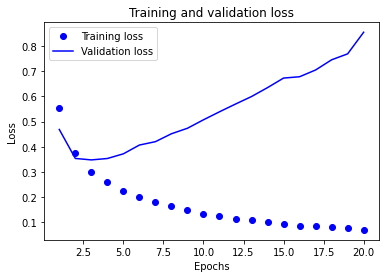

In [17]:
history_dict = LSTM_history.history

# 모델 학습 시각화
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점, b는 파란 실선
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

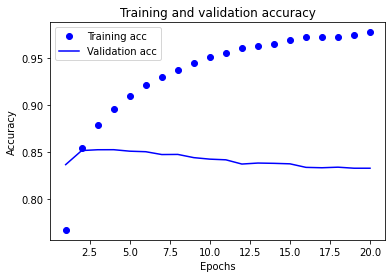

In [18]:
plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 1-D CNN Model

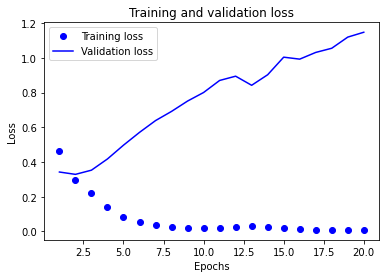

In [19]:
history_dict = CNN_1D_history.history

# 모델 학습 시각화
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점, b는 파란 실선
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

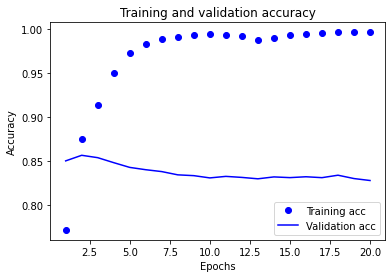

In [20]:
plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GRU Model

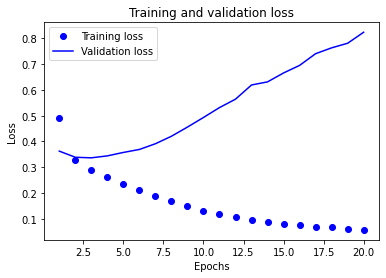

In [21]:
history_dict = GRU_history.history

# 모델 학습 시각화
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점, b는 파란 실선
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

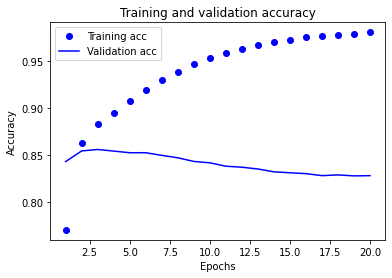

In [22]:
plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (7) 학습된 Embedding 레이어 분석

In [23]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)  # vocab_size, embedding_dim

(10000, 300)


In [24]:
# 학습한 embedding 파라미터를 파일로 저장
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 어떤 사이즈로 기재할지의 타이틀.

# 단어 개수(특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
# gensim에서 제공하는 패키지로, 위에서 만든 임베딩 파라미터를 익어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['연기']
vector

array([-0.05512848, -0.04809355, -0.00646178, -0.08521131,  0.02675703,
       -0.10543051, -0.06635085, -0.1428208 ,  0.1540037 ,  0.02270366,
       -0.072281  , -0.08266415, -0.07271736,  0.03082131, -0.02884695,
       -0.00427706,  0.1091035 ,  0.01851515,  0.12162277, -0.09639622,
        0.02388581,  0.11753675,  0.02086418, -0.01782572,  0.04531582,
        0.02114516, -0.05309874,  0.00283752,  0.14238302, -0.03383391,
       -0.08021746,  0.00821234, -0.02571228,  0.02055516,  0.05831509,
       -0.02185476, -0.07217657,  0.05119485, -0.12836975, -0.03519372,
       -0.05258074,  0.03975747,  0.07412063, -0.01686333,  0.03944597,
        0.15701512,  0.026435  , -0.0339375 , -0.00219466, -0.02419754,
       -0.12389371,  0.01803025,  0.01791334,  0.07704403,  0.0312174 ,
        0.05538494, -0.10415702, -0.09547707, -0.02392065, -0.10603312,
       -0.07147384,  0.04245614,  0.00170948,  0.122642  ,  0.09905072,
        0.10555063, -0.09623487,  0.06929443, -0.06594176,  0.04

In [26]:
word_vectors.similar_by_word("연기")

[('며', 0.7572504878044128),
 ('사랑', 0.7423205971717834),
 ('역시', 0.7352275252342224),
 ('씬', 0.7059164643287659),
 ('그리고', 0.6945496797561646),
 ('면서', 0.6938525438308716),
 ('웃겨', 0.6902435421943665),
 ('엄청나', 0.6887118220329285),
 ('구원', 0.6777993440628052),
 ('중', 0.6715244054794312)]

## (8) 한국어 Word2Vec 임베딩 활용해 성능 개선

In [27]:
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/ko.bin'
# 300dim의 벡터로 이루어진 300만 개의 단어를 모두 메모리에 로딩하면 실습환경에 따라 메모리 에러가 날 수 있다. 
# KeyedVector.load_word2vec_format 메서드로 가장 많이 사용되는 상위 100만개만 limit으로 설정해 로드
word2vec = Word2Vec.load(word2vec_path)
vector = word2vec['연기']
vector

/tmp/ipykernel_2558/3041951138.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['연기']


array([-5.3693395e-02, -7.8077865e-01,  9.6723193e-01, -7.4758315e-01,
       -8.9660138e-01, -1.3199822e+00,  6.2043767e-04, -6.7502671e-01,
        1.3555537e-01, -6.8331599e-01,  1.9583182e-01,  1.0852404e+00,
        2.1468368e-01,  2.8309336e-01, -4.0457886e-01, -3.6459949e-02,
        5.6666532e-03, -5.4509687e-01,  2.2584310e+00, -5.6259340e-01,
        6.5086263e-01, -1.8419718e+00, -2.1760310e-01, -1.0132394e+00,
        1.5185098e-01, -1.8222044e+00, -1.3982623e+00,  1.7238414e+00,
       -1.3829633e+00,  6.1575718e-02,  7.3994440e-01,  1.0549146e+00,
       -5.4366481e-01,  6.0019165e-02,  4.3806583e-01, -7.5868535e-01,
        1.2300022e+00, -7.9196030e-01, -1.6581323e+00, -3.9155692e-01,
       -1.3105632e+00,  8.5336879e-02, -2.7811906e-01, -1.2887888e-01,
        1.5672020e+00, -1.0730708e-01,  3.4074798e-01, -5.3951442e-01,
        5.1790684e-01,  1.5970176e+00,  1.5166098e+00, -1.9613689e-02,
       -1.0175781e+00,  1.0776117e-02, -4.1133726e-01, -4.0709490e-01,
      

In [28]:
word2vec.similar_by_word("연기")

/tmp/ipykernel_2558/1731032598.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("연기")


[('연출', 0.5039602518081665),
 ('뮤직비디오', 0.468474805355072),
 ('주연', 0.45783281326293945),
 ('출연', 0.4573212265968323),
 ('안무', 0.4553908705711365),
 ('캐스팅', 0.43967583775520325),
 ('조연', 0.4288240671157837),
 ('단역', 0.4258745610713959),
 ('영화화', 0.4199691116809845),
 ('냄새', 0.4133602976799011)]

In [29]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩 차례로 카피
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2558/2221020419.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2558/2221020419.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [30]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

# 모델 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer=Constant(embedding_matrix),
                                   input_length=maxlen,
                                   trainable=True))  # trainable=True면 Fine-tuning
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 2,470,105
Trainable params: 2,470,105
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
392/392 [==============================] - 9s 18ms/step - loss: 0.4500 - accuracy: 0.7841 - val_loss: 0.3560 - val_accuracy: 0.8443
Epoch 2/20
392/392 [==============================] - 7s 17ms/step - loss: 0.3187 - accuracy: 0.8639 - val_loss: 0.3176 - val_accuracy: 0.8624
Epoch 3/20
392/392 [==============================] - 7s 17ms/step - loss: 0.2705 - accuracy: 0.8877 - val_loss: 0.3380 - val_accuracy: 0.8619
Epoch 4/20
392/392 [==============================] - 7s 17ms/step - loss: 0.2327 - accuracy: 0.9054 - val_loss: 0.3191 - val_accuracy: 0.8657
Epoch 5/20
392/392 [==============================] - 7s 17ms/step - loss: 0.1960 - accuracy: 0.9222 - val_loss: 0.3424 - val_accuracy: 0.8639
Epoch 6/20
392/392 [==============================] - 7s 17ms/step - loss: 0.1576 - accuracy: 0.9386 - val_loss: 0.3864 - val_accuracy: 0.8644
Epoch 7/20
392/392 [==============================] - 7s 17ms/step - loss: 0.1230 - accuracy: 0.9525 - val_loss: 0.4244 - val_accuracy: 0.8594

In [32]:
# 모델 평가

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 1.0309 - accuracy: 0.8502
[1.030946969985962, 0.8501535654067993]


## 회고
LSTM과 1-D CNN외에 LSTM을 간단하게 만든 GRU 모델을 썼는데 큰 차이는 없었다. 자연어를 토큰화나 전처리하는 작업이 굉장히 까다롭구나하는 생각이 들었다.  
그 부분에 조금 더 신경쓰고, 모델의 하이퍼 파라미터의 적정값을 잘 찾아낼 수 있다면 조금 더 좋은 결과를 얻을 수 있을 것 같다.  
한국어 Word2Vec 임베딩은 확실히 놀라웠다. '연기'라는 단어를 주었을 때 상당히 연관성있는 단어들을 제시했다.  
다만 짧은 지식으로 추측컨대 한국어의 자연어 처리가 영어보다 어려운 듯한(불용어라던지...) 느낌이 들었다. 아무튼, 조금 더 깊이있게 공부해야겠다는 생각이 든다. 